In [3]:
import numpy as np
import scipy as sp
import torch
import time
import copy
import pickle
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys
import cvxpy as cp
from scipy.stats import norm
from itertools import product
sys.path.insert(0, os.path.abspath('../../'))

In [4]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Create data

In [5]:
def mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean):
    
    # Create sample from mixture of Gaussians
    X = np.zeros((2*n,n_features))
    for ct, mean_ in enumerate(means):            
        X[nodes_per_mean[ct],:] = std_ * np.random.randn(len(nodes_per_mean[ct]), n_features) + mean_
    X_ = np.zeros((2*n,n_features+1))
    X_[:,:-1] = X
    X_[:,-1]  = np.ones(2*n)
    
    # labels
    y = np.zeros(2*n)
    y[0:n] = 1
    
    return X_, y

def sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean):
    
    # Create matrix related to the graph
    g = nx.stochastic_block_model(sizes, probs)
    A = nx.adjacency_matrix(g)
    A.setdiag(A.diagonal() + 1)
    d_mat = np.sum(A, axis=0)
    dinv_mat = 1/d_mat
    d = d_mat.tolist()[0]
    dinv = dinv_mat.tolist()[0]
    D = sp.sparse.diags(d, 0)
    Dinv = sp.sparse.diags(dinv, 0)
    
    # Create sample from mixture of Gaussians
    X = np.zeros((2*n,n_features))
    for ct, mean_ in enumerate(means):            
        X[nodes_per_mean[ct],:] = std_ * np.random.randn(len(nodes_per_mean[ct]), n_features) + mean_

    # Create data
    data_ = Dinv@A@X

    # Append a column of ones for the coefficients of the bias
    data = np.zeros((2*n,n_features+1))
    data[:,:-1] = data_
    data[:,-1]  = np.ones(2*n)
    
    # labels
    y = np.zeros(2*n)
    y[0:n] = 1
    
    return data, y

# Create training and testing data

In [6]:
# Dimensions
n = 200
n_features = 6*int(np.ceil(2*n/(np.log(2*n)**2))) # 10*int(np.ceil(np.log(2*n)))

# Parameters for SBM
lb = 1/(2*n)
up = 0.5
ps = np.linspace(lb, up, 25, endpoint=True)
qs = 0.2*ps

# Number of trials
trials = 10

# Mean
mu = 1/n_features

In [7]:
train_datasets_per_p = {}
train_datasets_log = {}
test_datasets_per_p = {}
test_datasets_log = {}
# Parameters for mixture of Gaussians
std_ = 1/np.sqrt(n_features)
means = [mu,-mu]
nodes_per_mean = [list(range(n)),list(range(n,2*n))]    
# Train datasets without the graph
for trial in range(trials):
    X, y = mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean)
    train_datasets_log[trial] = [X, y]
# Test datasets without the graph
for trial in range(trials):
    X, y = mixture_of_Gaussians(n, n_features, std_, means, nodes_per_mean)
    test_datasets_log[trial] = [X, y]
for idx, p in enumerate(ps):        
    # SBM parameters
    probs = [[p, qs[idx]], [qs[idx], p]]
    sizes = [n, n]
    # Train datasets with the graph
    train_datasets = {}
    for trial in range(trials):
        # Training data
        X, y = sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean)
        train_datasets[trial] = [X, y]
    train_datasets_per_p[p] = train_datasets
    # Test datasets with the graph
    test_datasets = {}
    for trial in range(trials):
        # Test data
        data, y = sbm_mixture_of_Gaussians(n, n_features, sizes, probs, std_, means, nodes_per_mean)
        test_datasets[trial] = [data, y]
    test_datasets_per_p[p] = test_datasets

/Users/aseemrb/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Solver

In [8]:
def ipm(n, n_features, max_iter, data, y, verbose):

## Changed to CVX to get better accuracy because simple GD sucks.
    w = cp.Variable(n_features + 1)    
    log_likelihood = -1.0e-10*cp.sum_squares(w) + (cp.sum(cp.multiply(y, data @ w) - cp.logistic(data @ w)))/(2*n)
    objective = cp.Maximize(log_likelihood)
    constraints = [cp.norm(w[0:n_features],2) <= n_features]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='ECOS', verbose = verbose, reltol=1.0e-10, abstol=1.0e-10, feastol=1.0e-10, max_iters=max_iter)
#     result = prob.solve(solver='SCS', eps=1.0e-10, verbose = verbose, max_iters=max_iter)
    
    return w.value

# Do training

In [9]:
all_w_log = {}
avg_log = 0
for trial in range(trials):
    [X, y] = train_datasets_log[trial]
    w_log = ipm(n, n_features, 100, X, y, False)
    all_w_log[trial] = w_log
    # Compute the loss for "without the graph"
    sigma = 1/(1+np.exp(-X@w_log))
    avg_log += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n) #obj/(2*n)    
avg_log /= trials
plots_log = avg_log
print("obj (without graph): ", avg_log)

all_w_per_p = {}
plots = []
for p in ps:
    train_datasets = train_datasets_per_p[p]
    all_w = {}
    avg = 0
    for trial in range(trials):
        [X, y] = train_datasets[trial]
        w = ipm(n, n_features, 100, X, y, False)
        all_w[trial] = w
        # Compute the loss for "with the graph"
        sigma = 1/(1+np.exp(-X@w))
        avg += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n) #obj/(2*n)   
    avg /= trials
    print("p: ", p, " obj (with graph): ", avg)
    plots.append(avg)
    all_w_per_p[p] = all_w

/Users/aseemrb/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
obj (without graph):  0.2475813522607108
p:  0.0025  obj (with graph):  0.19960189202098474
p:  0.023229166666666665  obj (with graph):  0.06929615250191823
p:  0.043958333333333335  obj (with graph):  0.03101102924007404
p:  0.0646875  obj (with graph):  0.02240958349721506
p:  0.08541666666666667  obj (with graph):  0.012515222052015454
p:  0.10614583333333333  obj (with graph):  0.010812002789367154
p:  0.126875  obj (with graph):  0.007926965437678615
p:  0.14760416666666668  obj (with graph):  0.006790784406233902
p:  0.16833333333333333  obj (with graph):  0.006812973110482169
p:  0.1890625  obj (with graph):  0.00640258708564007
p:  0.20979166666666665  obj (with graph):  0.006032436559750278
p:  0.23052083333333334  obj (with graph):  

# Do testing

In [10]:
# Compute test error with graph
plots_test = []
for p in ps:
    test_datasets = test_datasets_per_p[p]
    all_w = all_w_per_p[p]
    avg = 0
    for trial, trial2 in product(range(trials),range(trials)):
        w = all_w[trial]
        [X, y] = test_datasets[trial2] 
        sigma = 1/(1+np.exp(-X@w))
        avg += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n) #obj/(2*n)  
    avg /= trials**2
    plots_test.append(avg)

# Compute test error without the graph
avg = 0
for trial, trial2 in product(range(trials),range(trials)):
    w = all_w_log[trial]
    [X, y] = test_datasets_log[trial2] 
    sigma = 1/(1+np.exp(-X@w))
    avg += np.sum(-y*np.log(sigma + 1.0e-12) - (1-y)*np.log(1-sigma + 1.0e-12))/(2*n) #obj/(2*n)  
avg /= trials**2
plots_log_test = avg

## Plot

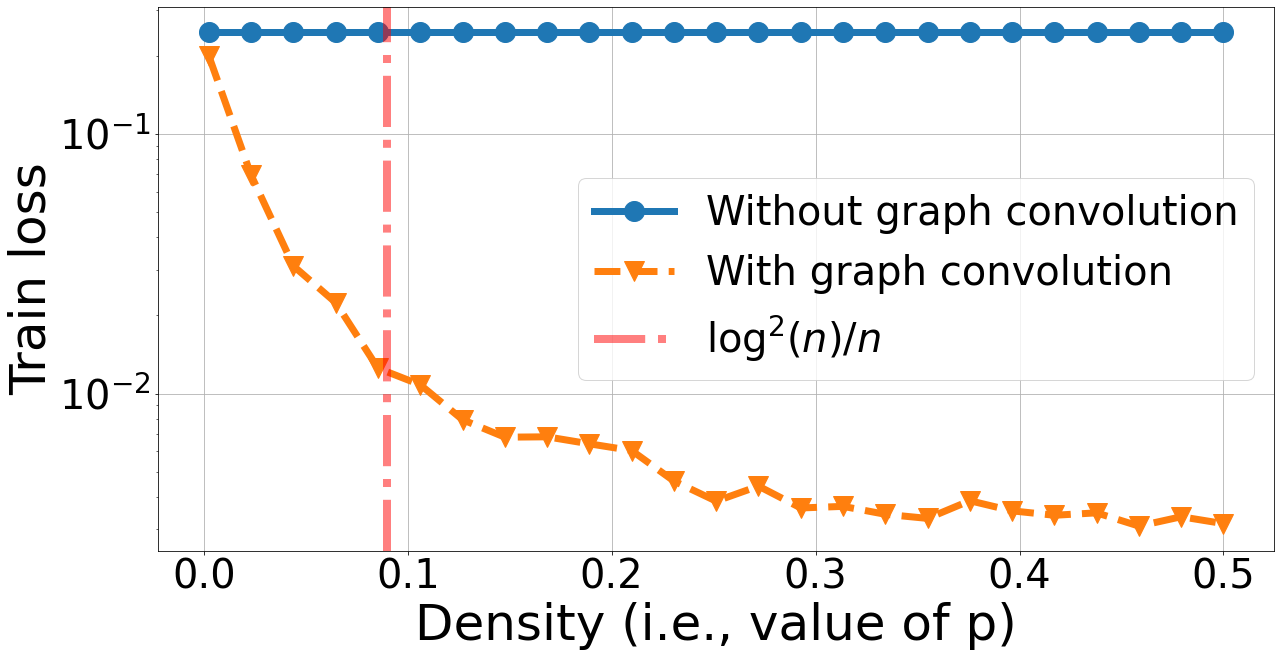

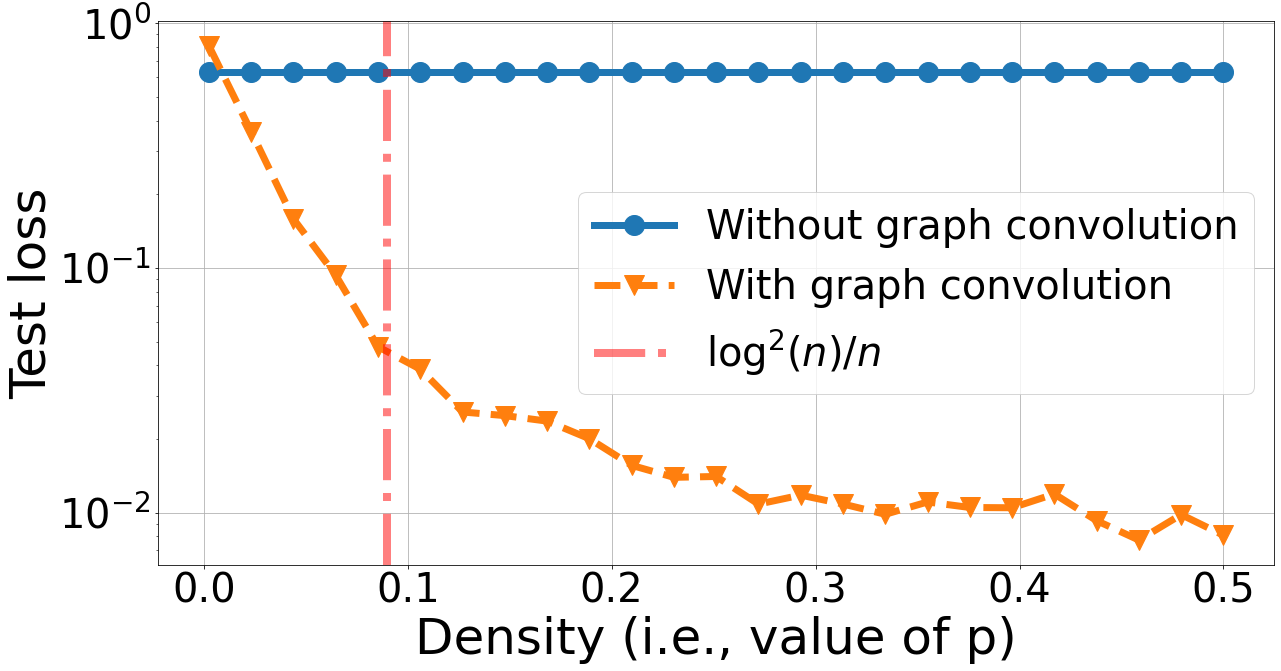

In [11]:
fig = plt.figure(figsize=(20,10), facecolor=[1,1,1])
ax = plt.axes()

ax.plot(ps, plots_log*np.ones(len(ps)), linewidth=7, linestyle= '-', marker='o', markersize=20, label='Without graph convolution')
ax.plot(ps, plots, linewidth=7, linestyle='--', marker='v', markersize=20, label='With graph convolution')
ax.axvline(x=np.log(2*n)**2/(2*n), color='red', linewidth=8, linestyle='-.', alpha=0.5, label=r'$\log^2(n)/n$')

ax.set_xlabel('Density (i.e., value of p)', fontsize=50)
ax.set_ylabel('Train loss', fontsize=50)
ax.legend(loc='best', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.yscale('log')
ax.grid()

fig.savefig('loss_vs_density_train_result_trained_on_n.pdf', bbox_inches='tight')

# Plot test error
fig = plt.figure(figsize=(20,10), facecolor=[1,1,1])
ax = plt.axes()
    
ax.plot(ps, plots_log_test*np.ones(len(ps)), linewidth=7, linestyle= '-', marker='o', markersize=20, label='Without graph convolution')
ax.plot(ps, plots_test, linewidth=7, linestyle='--', marker='v', markersize=20, label='With graph convolution')
ax.axvline(x=np.log(2*n)**2/(2*n), color='red', linewidth=8, linestyle='-.', alpha=0.5, label=r'$\log^2(n)/n$')

ax.set_xlabel('Density (i.e., value of p)', fontsize=50)
ax.set_ylabel('Test loss', fontsize=50)
ax.legend(loc='best', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.yscale('log')
ax.grid()

fig.savefig('loss_vs_density_test_result_trained_on_n.pdf', bbox_inches='tight')